## UQR2216 Assignment 2: Motor Third-Party Liability Claims Analysis and Prediction
### Tian Mengxi (e0555841)

Acknowledgement: 
This assignment was done with reference to and with the use of code segments from the Regression-GLM_Interaction Variable(-Collinearity).ipynb file uploaded to LumiNUS. 

### Importing the relevant packages

In [101]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_partregress_grid
import math
import regex as re
import matplotlib.pyplot as plt


#set maximum window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #change code window width to max
pd.options.display.max_columns = 0 #change output window width to max
plt.ion()

### Reading and Cleaning Up Data
1. Drop rows with any missing values
2. Drop the column for IDpol because it is not a regression variable for ClaimNb

In [102]:
d = 1 #use specified dataset
dt = pd.read_csv('FrenchMotorThirdPartyLiabilityClaims.csv') #specifying 1st column as row labels (called 'index')

#Dropping the IDpol column
del dt['IDpol'] 

#Set up the dependent variable as ClaimNb 
yname = 'ClaimNb' 

#Data cleaning: delete any row with any missing value
dt.dropna(how='any', inplace=True)
if yname != dt.columns[0]:
    dt = dt[[yname] + list(dt.columns.drop(yname))]

#Only take values of ClaimNb <= 4, because of possibility of unreasonable observations (due to data error)
dt['ClaimNb'] = dt['ClaimNb'].clip(upper=4)
print('Dataset has', len(dt), 'rows.\n')

#Summary of the dataset
#The dataset consists of 678,013 samples, 10 explanatory variables. 
display(dt.describe())
display(dt.describe(include=[np.object]))

#See first ten rows of the dataset
with pd.option_context('display.max_rows', 10):
    display(dt)

Dataset has 678013 rows.



,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053179,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.237954,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,4.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12','Regular','R24'
freq,191880,166024,345877,160601


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


### Building a negative binomial regression model to predict the dependent variable 'ClaimNb'

In [103]:
#Step 1: Accounting for Collinearity between the regression variables

m2 = '7'
m = 'NegativeBinomial'
dist = sm.families.NegativeBinomial()
ytype = type('a')
df = sm.add_constant(dt.iloc[:, 1:])
y = dt.iloc[:, 0]
ytype = type(y)
    
m3 = '2'

def delcorr(df):
    #delete any x too highly correlated with another x, to avoid collinearity
    corv = df.iloc[:, 1:].corrwith(df[yname] if m == 'Normal' else y).rename(yname).sort_values(key=abs).to_frame()

    delta = 0.005 #corr difference lower limit
    dl2 = []
    icorr = True
    while icorr:
        a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
        colname = list(df)[1:]
        dl = []
        print('\nX pairs with correlations >', 1 - delta, ':')
        for b in range(1, a.shape[0]):
            if a.iloc[b, 0]:
                if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                    #deleting 1 X from correlated pair:
                    dv0 = a.index[b - 1]
                    dv1 = a.index[b]

                    #neither should already be deleted:
                    if not (dv0 in dl) and not (dv1 in dl):
                        #delete x with rather lower corr(x, y):
                        if abs(corv.loc[dv0, y if type(y) == type('a') else y.name]
                              ) - abs(corv.loc[dv1, y if type(y) == type('a') else y.name]) >= delta:
                            d = dv1
                        elif len(dv0) < len(dv1): #delete x with longer name:
                            d = dv1
                        else:
                            d = dv0

                        dl.append(d) #for en masse deletion later
                        corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                        print(dv0,',',dv1)

        if len(dl) > 0:
            df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
            dl2 = dl2 + dl #keep for real deletion later
            print('\n' + str(len(dl)), 'variables considered for deletion:')
            print('\n'.join([str(x) for x in dl]))
        else:
            print('(no more)')
            icorr = False
    return dl2
            
#delete collinear Xs:
dl2 = delcorr(df)
#df.drop(axis=1, columns=dl2, inplace=True) #collinear Xs deleted en masse #not necessary since df operated on directly
if len(dl2) > 0:
    print('\n' + str(len(dl2)) + ' variables deleted.')


X pairs with correlations > 0.995 :
(no more)


In [104]:
#Step 2: Transform X-variables, while still trying to avoiding collinearity

#transform all Xs into either square & square-root or cube & cube-root using np.cbrt()
trf = ['_sqar', '_sqrt', '_cube', '_cbrt']

for i in list(df)[1:]:
    #excluded either y or column of 1s
    try:
        #searching for -ve values:
        df[i + trf[1]] = np.sqrt(df[i])
        df[i + trf[0]] = df[i] ** 2.
    except:
        try:
            #searching for non-numeric
            df[i + trf[0]] = df[i] ** 3.
            df[i + trf[1]] = np.cbrt(df[i])
        except:
            #column cannot be transformed
            #delete non-numeric column (with no questions asked!):
            df.drop(i, axis=1, inplace=True) #remove any row with any NaN

#delete collinear Xs:
df0 = df.copy()
dl2 = delcorr(df0)
dl2 = [x for x in dl2 if x[-5:] in trf]
if len(dl2) > 0:
    df.drop(axis=1, columns=dl2, inplace=True) #collinear transformed variables deleted en masse
    print('\n' + str(len(dl2)) + ' transformed variables deleted.')


X pairs with correlations > 0.995 :
VehPower_sqrt , VehPower
BonusMalus_sqrt , BonusMalus

2 variables considered for deletion:
VehPower_sqrt
BonusMalus_sqrt

X pairs with correlations > 0.995 :
(no more)

2 transformed variables deleted.



Fit using random 80% (x_train & y_train) of data rows:

OLS fit including only 6 untransformed Xs:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.012      
Dependent Variable: ClaimNb          AIC:                -25498.4260
Date:               2021-03-31 13:53 BIC:                -25419.9996
No. Observations:   542410           Log-Likelihood:     12756.     
Df Model:           6                F-statistic:        1067.      
Df Residuals:       542403           Prob (F-statistic): 0.00       
R-squared:          0.012            Scale:              0.055860   
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
Intercept       -0.0753    0.0026  -29.1108  0.0000  -0.0804  -0.0702
Exposure         0.0560    0.0009   61.1649  0.0000   0.0542   0.0578
BonusMalus       

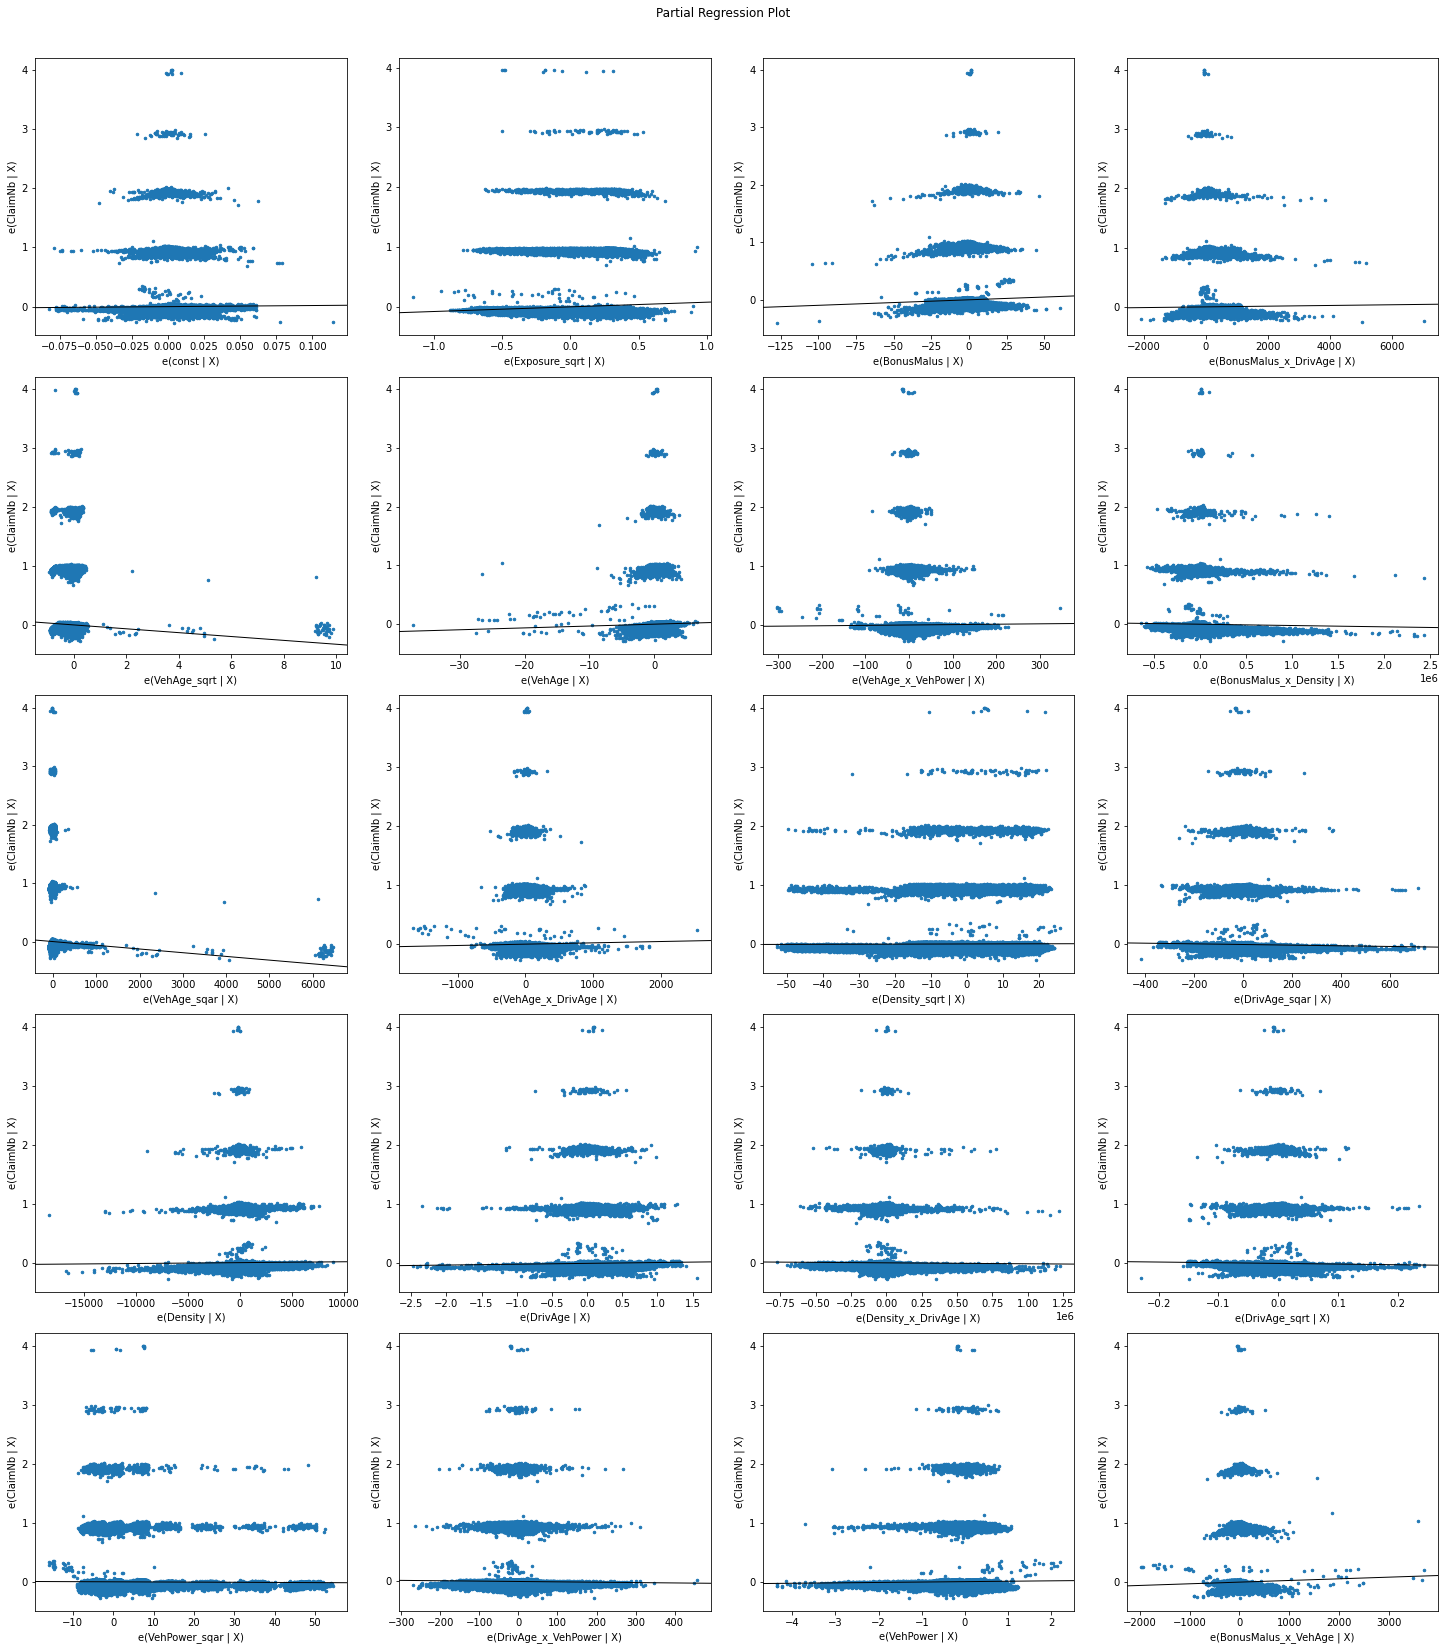


NegativeBinomial fit using random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.09924416878076862
Root Mean Squared Residual = 0.23568219626107723
                        R² = 0.017212278504160416

NegativeBinomial prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.09905758830128136
Root Mean Squared Error = 0.2366567922121658
                     R² = 0.01806134685109253

Plots of train-set fit & test-set predict:


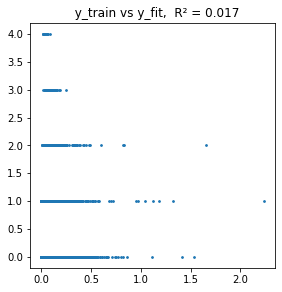

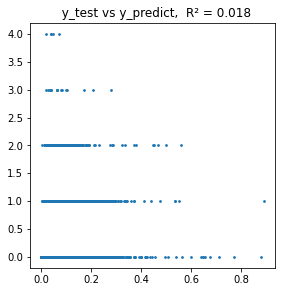

In [105]:
#Step 3: split into training & testing sets (by Random Train Test Split) and choosing the set of variables
#that would result in the best adjusted R^2

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:] if m == 'Normal' else df,
            df[y] if m == 'Normal' else y, test_size=.2,
            random_state=(None if m3=='2' else m3)) #set to an integer (here m3) to get reproducible output

#sort columns by absolute correlation with y, so may preferably delete last column if regression fails:
x_train = x_train[x_train.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]

print('\nFit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:')

#first do OLS on untransformed Xs:
df = pd.concat([y_train, x_train if m == 'Normal' else x_train.iloc[:, 1:]], axis=1)
xpure = [x for x in list(df) if x[-5:] not in trf]
numx = len(xpure) - 1
print('\nOLS fit including only', numx, 'untransformed Xs:')

#initialize for adj-R2:
ddf = np.inf #deficiency in degree of freedom = rank deficiency
maxR2 = -np.inf
bmodeleq = ''

bic0 = np.inf #bic kept by lowest overall rank deficiency
bic5 = bic0   #bic kept by best model with p-values < 0.05
bicd = bic0   #bic kept by lowest rank deficiency
bbic = bic0   #best bic kept by adj-R2

p05 = False #once found all Xs' p-values < 0.05

modeleq = ' + '.join(list(xpure)).replace('+', '~', 1)
try:
    out = ols(modeleq, df).fit()
    print(out.summary2())
    if numx > 1:
        print("\nDescending order of", numx, "X's significance, assuming", m, 'error distribution:')
        print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
        #if the single best variable isn't high in above ranking, collinearity might be an issue
    
    dfm = int(out.df_model)

    ddf = numx - dfm #rank deficiency
    maxR2 = out.rsquared_adj
    bmodeleq = modeleq
    print('\n' + 'Rank deficiency =', str(ddf) + ': Df Model (' + str(dfm) + ') is',
          ('less than' if ddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
except:
    pass
    
print('\n'+ m, 'fit including transformed Xs:')

if m != 'Normal':
    #undo above ols:
    ddf = np.inf
    maxR2 = -np.inf
    bmodeleq = ''
    
    df = x_train
    y = y_train
    
#initialize for rank deficiency:
ddfd = ddf #best rank deficiency
R2df = maxR2 #R2 for best rank deficiency
modeleqdf = bmodeleq #modeleq for best rank deficiency

#initialize for overall rank deficiency
ddf0 = ddfd
R2df0 = R2df
modeleqdf0 = modeleqdf

bddf = ddfd #rank deficiency for best adj-R2 model

#initialize for z-stat p-values < 0.05:
ddf5 = np.inf #rank deficiency for best model with p-values < 0.05
R205 = -np.inf #adj-R2 for best model with p-values < 0.05
modeleq05 = '' #modeleq for best model with p-values < 0.05

df0 = df.copy() #kept for inclusion of interaction variables later

#perform feature selection using adjusted R2

#model equation actually not used by GLM:
modeleq = ' + '.join(list(df)).replace('+', '~', 1)
#print(modeleq)
numx = df.shape[1] - 1

x1x2 = False #interaction variables not yet included

while True:
    #GLM distribution
    try:
        out = sm.GLM(y, df, family=dist).fit()
        R2 = 1 - (1 - y.corr(out.fittedvalues)**2) * (out.nobs - 1) / out.df_resid #pseudo adjusted r2
        if R2 != R2 and out.fittedvalues.isna().sum() == 0:
            R2 = -np.inf
            #R2 = -out.bic
    except:
        #GLM failed!  do ols for this round, just to delete 1 x:
        try:
            out = ols(' + '.join(list(df)).replace('+', '~', 1), df).fit() #do OLS instead
        except:
            pass
        R2 = -np.inf
    
    try:
        maxp = max(out.pvalues[1:])
        dfm = int(out.df_model)
    except:
        maxp = 1
        dfm = 0
    ddf = numx - dfm #rank deficiency
    
    #see if a better model is found:
    try:
        if R2 >= maxR2 and out.fittedvalues.isna().sum() == 0:
            maxR2 = R2
            bmodeleq = modeleq
            bddf = min(bddf, ddf)

            ddf0 = ddf #best overall rank deficiency

            if maxR2 == -np.inf:
                bbic = out.bic

            if maxp >= 0.05 and not p05:
                #reset z-stat p-value criterion:
                R205 = -np.inf
                modeleq05 = ''

                #reset rank deficiency criterion:
                R2df = R205
                modeleqdf = ''
                ddfd = bddf #reset deficient df
            else:
                p05 = True
            #if m != 'Normal':
            #    df1 = df.copy()

        #see if a model is found with reduced overall rank deficiency:
        if ddf < ddf0 or (ddf == ddf0 and R2 > R2df0):
            R2df0 = R2
            modeleqdf0 = modeleq
            ddf0 = ddf #best overall rank deficiency
            if maxR2 == -np.inf:
                bic0 = out.bic

        #see if a better model is found with max(z-stat p-value) < .05:
        if maxp < .05 and (R2 > R205 or modeleq05 == ''):
            R205 = R2
            modeleq05 = modeleq
            ddf5 = min(ddf5, ddf) #rank deficiency for best model with p-values < .05
            if maxR2 == -np.inf:
                bic5 = out.bic

        #see if a model is found with reduced rank-deficiency:
        if ddf < ddfd or (ddf == ddfd and R2 > R2df):
            R2df = R2
            modeleqdf = modeleq
            ddfd = min(ddfd, ddf) #best rank deficiency
            if maxR2 == -np.inf:
                bicd = out.bic
    except:
        pass

    print('\nAdjusted R² =', R2, ', max(X p-value) =', maxp, ', rank deficiency =', ddf, ', for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            if maxR2 == -np.inf and out.fittedvalues.isna().sum() > 0:
                print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
                #use all Xs before deletion:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            else:
                #see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
                if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
                    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
                    bmodeleq = modeleq05
                    maxR2 = R205
                    #bddf = min(bddf, ddf5)
                    bddf = ddf5
                    
                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bic5 #best bic
                        bic5 = np.inf #re-initialize

                #see if model with smallest rank-deficiency is smaller than best model so far:
                if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
                    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
                    bmodeleq = modeleqdf
                    maxR2 = R2df
                    #bddf = min(bddf, ddfd)
                    bddf = ddfd
                    
                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bicd #best bic
                        bicd = np.inf #re-initialize
        
                if maxR2 == -np.inf:
                    #reset z-stat p-value criterion:
                    R205 = -np.inf
                    modeleq05 = ''

                    #reset rank deficiency criterion:
                    R2df = R205
                    modeleqdf = ''
                    ddfd = np.inf #reset deficient df
            
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            if numx == 0:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs & Adjusted R² =', str(maxR2) + ') found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df0[colname]
            colname = colname[1:] #remove y or 'const'
            x_test = x_test[colname]
            
            xpure = [x for x in colname if x[-5:] not in trf] #untransformed x names
            i = len(xpure) - 1
            
            #actually, nothing to do if i<=0
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  'untransformed variables in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = xpure[j] + '_x_' + xpure[k]
                    print(a)
                    df[a] = df[xpure[j]] * df[xpure[k]]
                    x_test[a] = x_test[xpure[j]] * x_test[xpure[k]]

            df0 = df.copy()
            
            #delete collinear Xs introduced:
            dl2 = delcorr(df)
            dl2 = [x for x in dl2 if x.find('_x_') != -1] #only interaction variables kept
            if len(dl2) > 0:
                df0.drop(axis=1, columns=dl2, inplace=True) #collinear interaction variables deleted en masse, for real
                x_test.drop(axis=1, columns=dl2, inplace=True)
                #remaining Xs may be collinear
                print('\n' + str(len(dl2)) + ' interaction variables deleted.')
            
            #potential collinearity issues handled
            
            #sort columns by absolute correlation with y, so may C delete last column if regression fails:
            df0 = df0[df0.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]

            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            if maxR2 == -np.inf:
                bddf = np.inf
                ddf5 = bddf
                ddfd = bddf
                p05 = False
            x1x2 = True #interaction variables already included
            
            df = df0.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = out.tvalues[1:]
    try:
        xdrop = list(t[abs(t) == min(abs(t))].index)[-1]
    except:
        xdrop = list(t.index)[-1]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

#see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
    bmodeleq = modeleq05
    maxR2 = R205
    bddf = ddf5

#see if model with smallest rank-deficiency is smaller than best model so far:
if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
    bmodeleq = modeleqdf
    maxR2 = R2df
    bddf = ddfd

if maxR2 == -np.inf and out.fittedvalues.isna().sum() > 0:
    #some nan in y fit
    print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
else:
    try:
        if bddf >= ddf0 and ((maxR2 > -np.inf and R2df0 >= maxR2) or (maxR2 == -np.inf and bic0 <= bbic)):
            bmodeleq_0 = bmodeleq
            maxR2_0 = maxR2
            bddf_0 = bddf
            
            #prefer smaller rank deficiency
            if m == 'Normal':
                out = ols(modeleqdf0, df0).fit()
            else:
                out = sm.GLM(y, df0[modeleqdf0.replace('~', '+').split(' + ')], family=dist).fit()
            if max(out.pvalues[1:]) < 0.05:
                #Xs' p-values < 0.05
                bmodeleq = modeleqdf0
                maxR2 = R2df0
                bddf = ddf0
    except:
        bmodeleq = bmodeleq_0
        maxR2 = maxR2_0
        bddf = bddf_0
        
    try:
        df0 = df0[bmodeleq.replace('~', '+').split(' + ')]
        out = sm.GLM(y, df0, family=dist).fit()
        x_test = sm.add_constant(x_test)[df0.columns]

        numx = bmodeleq.count('+') + 1
        print('\nBest model has', numx, 'Xs (Adjusted R² =', str(maxR2), ', rank deficiency =', str(bddf) + '):\n')
        print(out.summary2())

        if numx > 1:
            print("Descending order of", numx, "X's significance, assuming", m, 'error distribution:')
            print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
            #if the single best variable isn't high in above ranking, collinearity might be an issue

        dfm = int(out.df_model)
        print('\n' + 'Rank deficiency =', str(bddf) + ': Df Model (' + str(dfm) + ') is',
              ('less than' if bddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
        
        pl.rcParams['lines.markersize'] = 2.5
        pl.rcParams['lines.linewidth'] = 1

        #includes intercept; 4 plots to a row:
        nr = math.ceil((numx + 1) / 4) #number of rows of plots
        pl.rcParams["figure.figsize"] = (20.2, 14 / 3 * nr) #plot height depends on number of rows of plots
        print('\nPartial Leverage (or Partial Regression, or Added-Variable) diagnostic plots:')
        #grid(rows, columns) for plots; fixed at 4 columns of plots per row:
        plot_partregress_grid(out, grid=(nr, 4))
        pl.show()

        y_fit = out.fittedvalues
        y_train = df.iloc[:, 0] if m == 'Normal' else y
        print('\n'+ m, 'fit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:\n')
        print('    Mean Absolute Residual =', abs(y_train - y_fit).mean())
        print('Root Mean Squared Residual =', np.sqrt(((y_train - y_fit) ** 2.).mean()))
        r2_train = y_train.corr(y_fit) ** 2.
        print('                        R² =', r2_train)

        y_predict = out.predict(x_test) #forecast
        print('\n' + m, 'prediction using remaining 20% (x_test & y_test) of data rows:\n')
        print('    Mean Absolute Error =', abs(y_test - y_predict).mean())
        print('Root Mean Squared Error =', np.sqrt(((y_test - y_predict) ** 2.).mean()))
        r2_test = y_test.corr(y_predict) ** 2.
        print('                     R² =', r2_test)

        print('\nPlots of train-set fit & test-set predict:')

        pl.rcParams["figure.figsize"] = (20.2, 4.5)
        pl.subplot(1, 4, 1) #1 row, 4 columns, plot 1
        pl.title('  y_train vs y_fit,  R² = ' + str(round(r2_train, 3)))
        pl.scatter(y_fit, y_train, s=3)
        pl.show()

        #plot y_test vs y_predict
        pl.subplot(1, 4, 2) #1 row, 4 columns, plot 2
        pl.title('  y_test vs y_predict,  R² = ' + str(round(r2_test, 3)))
        pl.scatter(y_predict, y_test, s=3)
        pl.show()
    except:
         print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')

### Report on Findings

In [100]:
"""
My approach was to first narrow down the possible models that could possibly be used to predict ClaimNb. Since ClaimNb, 
which represents the number of claims in the given exposure period, takes only discrete non-negative values between 0 
and 16 (inclusive), it is a type of count-based data. For counts, Poisson regression and Negative Binomial regression 
are two of the most commonly used models, with the latter more appropriate when there is overdispersion. 

However, both models could not accurately predict the ClaimNb variable, producing adjusted R^2 values of between 0.013 to 
0.015. The code above, which uses the Negative Binomial regression yielded an adjusted R^2 of 0.015, which is very low. 
This suggests that neither models are able to accurately predict the ClaimNb, even after variable transformation. 

One observation I made is that the exposure in the dataset is not kept constant. Thus, a possible suggestion for future 
models is to first scale ClaimNb according to their exposure periods, and predict claim frequency (ClaimNb/exposure 
in years) instead. Furthermore, an Overdispersion Test testing the null hypothesis of equidispersion could first be 
carried out to test whether the assumption for Poisson holds, to decide whether to proceed with Negative Binomial or 
Poisson model. 
"""

'\nMy approach was to first narrow down the possible models that could possibly be used to predict ClaimNb. Since ClaimNb, \nwhich represents the number of claims in the given exposure period, takes only discrete non-negative values between 0 \nand 16 (inclusive), it is a type of count-based data. For counts, Poisson regression and Negative Binomial regression \nare two of the most commonly used models, with the latter more appropriate when there is overdispersion. \n\nHowever, both models could not accurately predict the ClaimNb variable, producing adjusted R^2 values of between 0.013 to \n0.015. The code above, which uses the Negative Binomial regression yielded an adjusted R^2 of 0.015, which is very low. \nThis suggests that neither models are able to accurately predict the ClaimNb, even after variable transformation. \n\nOne observation I made is that the exposure in the dataset is not kept constant. Thus, a possible suggestion for future \nmodels is to first scale ClaimNb accordi